In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import numpy as np

In [2]:
df = pd.read_excel('premiums_rest.xlsx')
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


In [3]:
df.shape

(29904, 13)

In [4]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

In [5]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [6]:
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


### Handling NA values

In [7]:
# Checking for NA values
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [8]:
# dropping rows with na feature values
df.dropna(inplace=True)

In [9]:
df.duplicated().sum()

0

In [10]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [11]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29886.000000,29886.000000,29886.000000,29886.000000
mean,43.396105,2.379910,23.364184,20892.303821
std,13.412657,1.431201,24.740339,6936.813440
min,26.000000,-3.000000,1.000000,3625.000000
25%,34.000000,1.000000,7.000000,15697.250000
50%,42.000000,3.000000,17.000000,20489.000000
75%,52.000000,3.000000,32.000000,26360.000000
max,356.000000,5.000000,930.000000,43471.000000


In [12]:
# Showing all the negative values from number_of_dependants column
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-1, -3], dtype=int64)

In [13]:
# making negative values of number_of_dependants positive
df['number_of_dependants'] = abs(df['number_of_dependants'])

In [14]:
df['number_of_dependants'].describe()

count    29886.000000
mean         2.385933
std          1.421137
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

### Data Visualization

In [15]:
# Filtering out all the numeric columns
num_columns = df.select_dtypes(['float64', 'int64']).columns

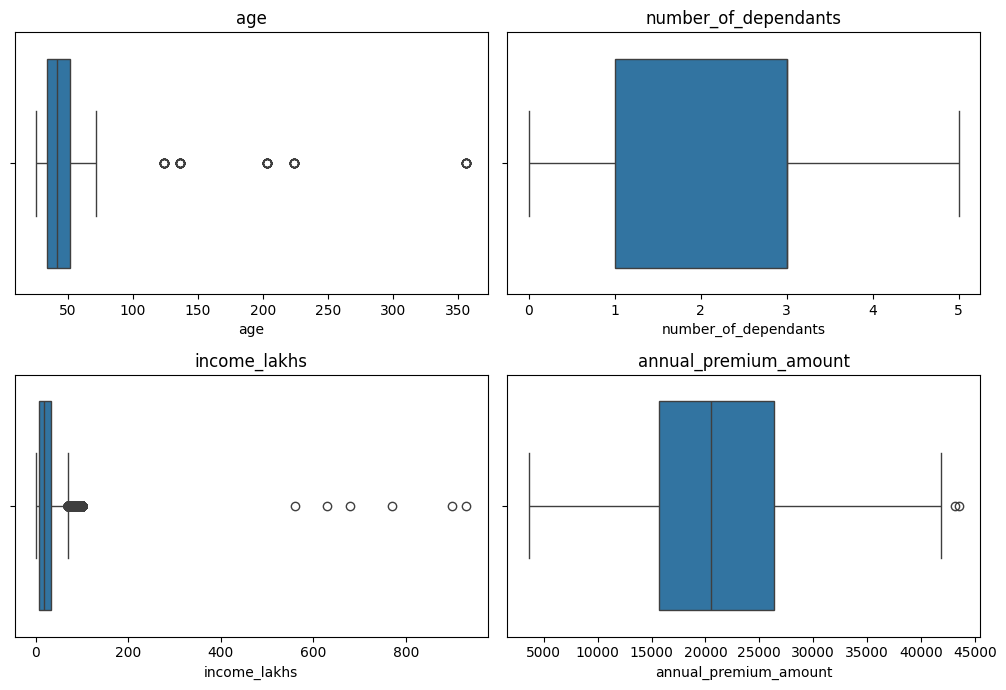

In [16]:
# Plotting box plot
plt.figure(figsize=(10, 7))

for i, column in enumerate(num_columns):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x=df[column])
    plt.title(column)

plt.tight_layout()
plt.show()

In [17]:
# Analyzing the outliers of age column
df[df['age']>100]['age'].unique()

array([224, 124, 136, 203, 356], dtype=int64)

In [18]:
df1 = df[df['age']<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29828.000000,29828.000000,29828.000000,29828.000000
mean,43.095380,2.387790,23.371530,20901.900563
std,11.041991,1.420641,24.751262,6928.457636
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15706.000000
50%,42.000000,3.000000,17.000000,20496.000000
75%,52.000000,3.000000,32.000000,26361.000000
max,72.000000,5.000000,930.000000,43471.000000


In [19]:
# Analyzing the outliers for 'income_lakhs' feature
# using quantile to set a reasonable threshold

income_quantile_threshold = df1.income_lakhs.quantile(0.999).copy()
print('income quantile threshold is:',income_quantile_threshold)

df2 = df1[df1.income_lakhs<=income_quantile_threshold].copy()
df2.income_lakhs.describe()

income quantile threshold is: 100.0


count    29822.000000
mean        23.226343
std         22.455408
min          1.000000
25%          7.000000
50%         17.000000
75%         32.000000
max        100.000000
Name: income_lakhs, dtype: float64

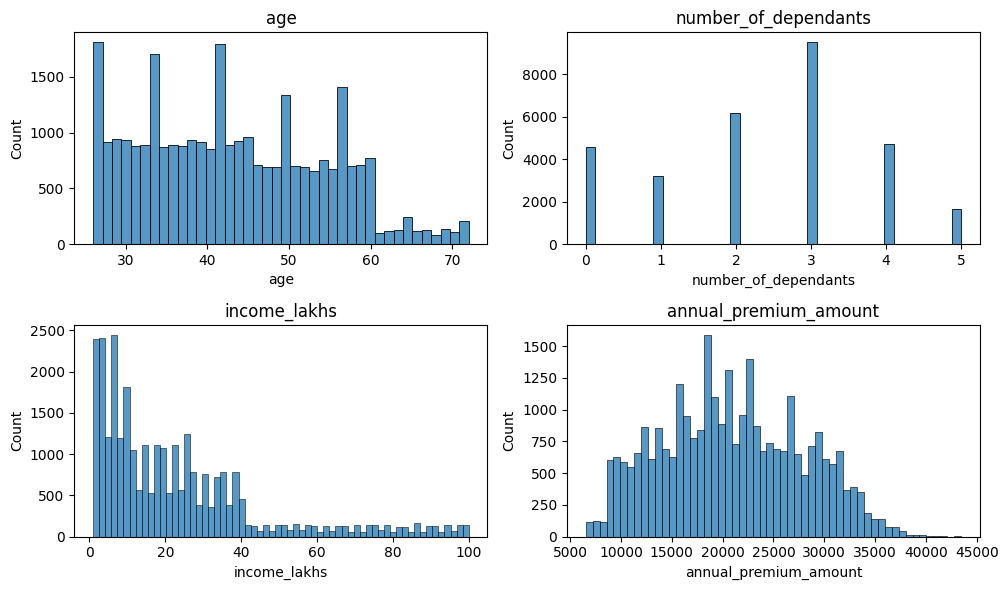

In [20]:
# Data Visualization

plt.figure(figsize=(10, 6))

for i, col in enumerate(num_columns):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df2[col])
    plt.title(col)

plt.tight_layout()
plt.show()


In [21]:
categorical_columns = ['income_level', 'employment_status', 'smoking_status', 'bmi_category', 'marital_status', 'gender', 'region', 'medical_history', 'insurance_plan']

for col in categorical_columns:
    print(col, df2[col].unique())

# Something fishy in smoking_status feature

income_level ['<10L' '10L - 25L' '> 40L' '25L - 40L']
employment_status ['Salaried' 'Self-Employed' 'Freelancer']
smoking_status ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
bmi_category ['Normal' 'Obesity' 'Overweight' 'Underweight']
marital_status ['Unmarried' 'Married']
gender ['Male' 'Female']
region ['Northwest' 'Southeast' 'Northeast' 'Southwest']
medical_history ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan ['Bronze' 'Silver' 'Gold']


In [22]:
df2['smoking_status'].replace({
    'Smoking=0':'No Smoking',
    'Does Not Smoke':'No Smoking',
    'Not Smoking':'No Smoking'
})

df2['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional', 'Does Not Smoke',
       'Not Smoking', 'Smoking=0'], dtype=object)

In [23]:
gender_percentage = df2['gender'].value_counts(normalize=True)
gender_percentage

gender
Male      0.549125
Female    0.450875
Name: proportion, dtype: float64

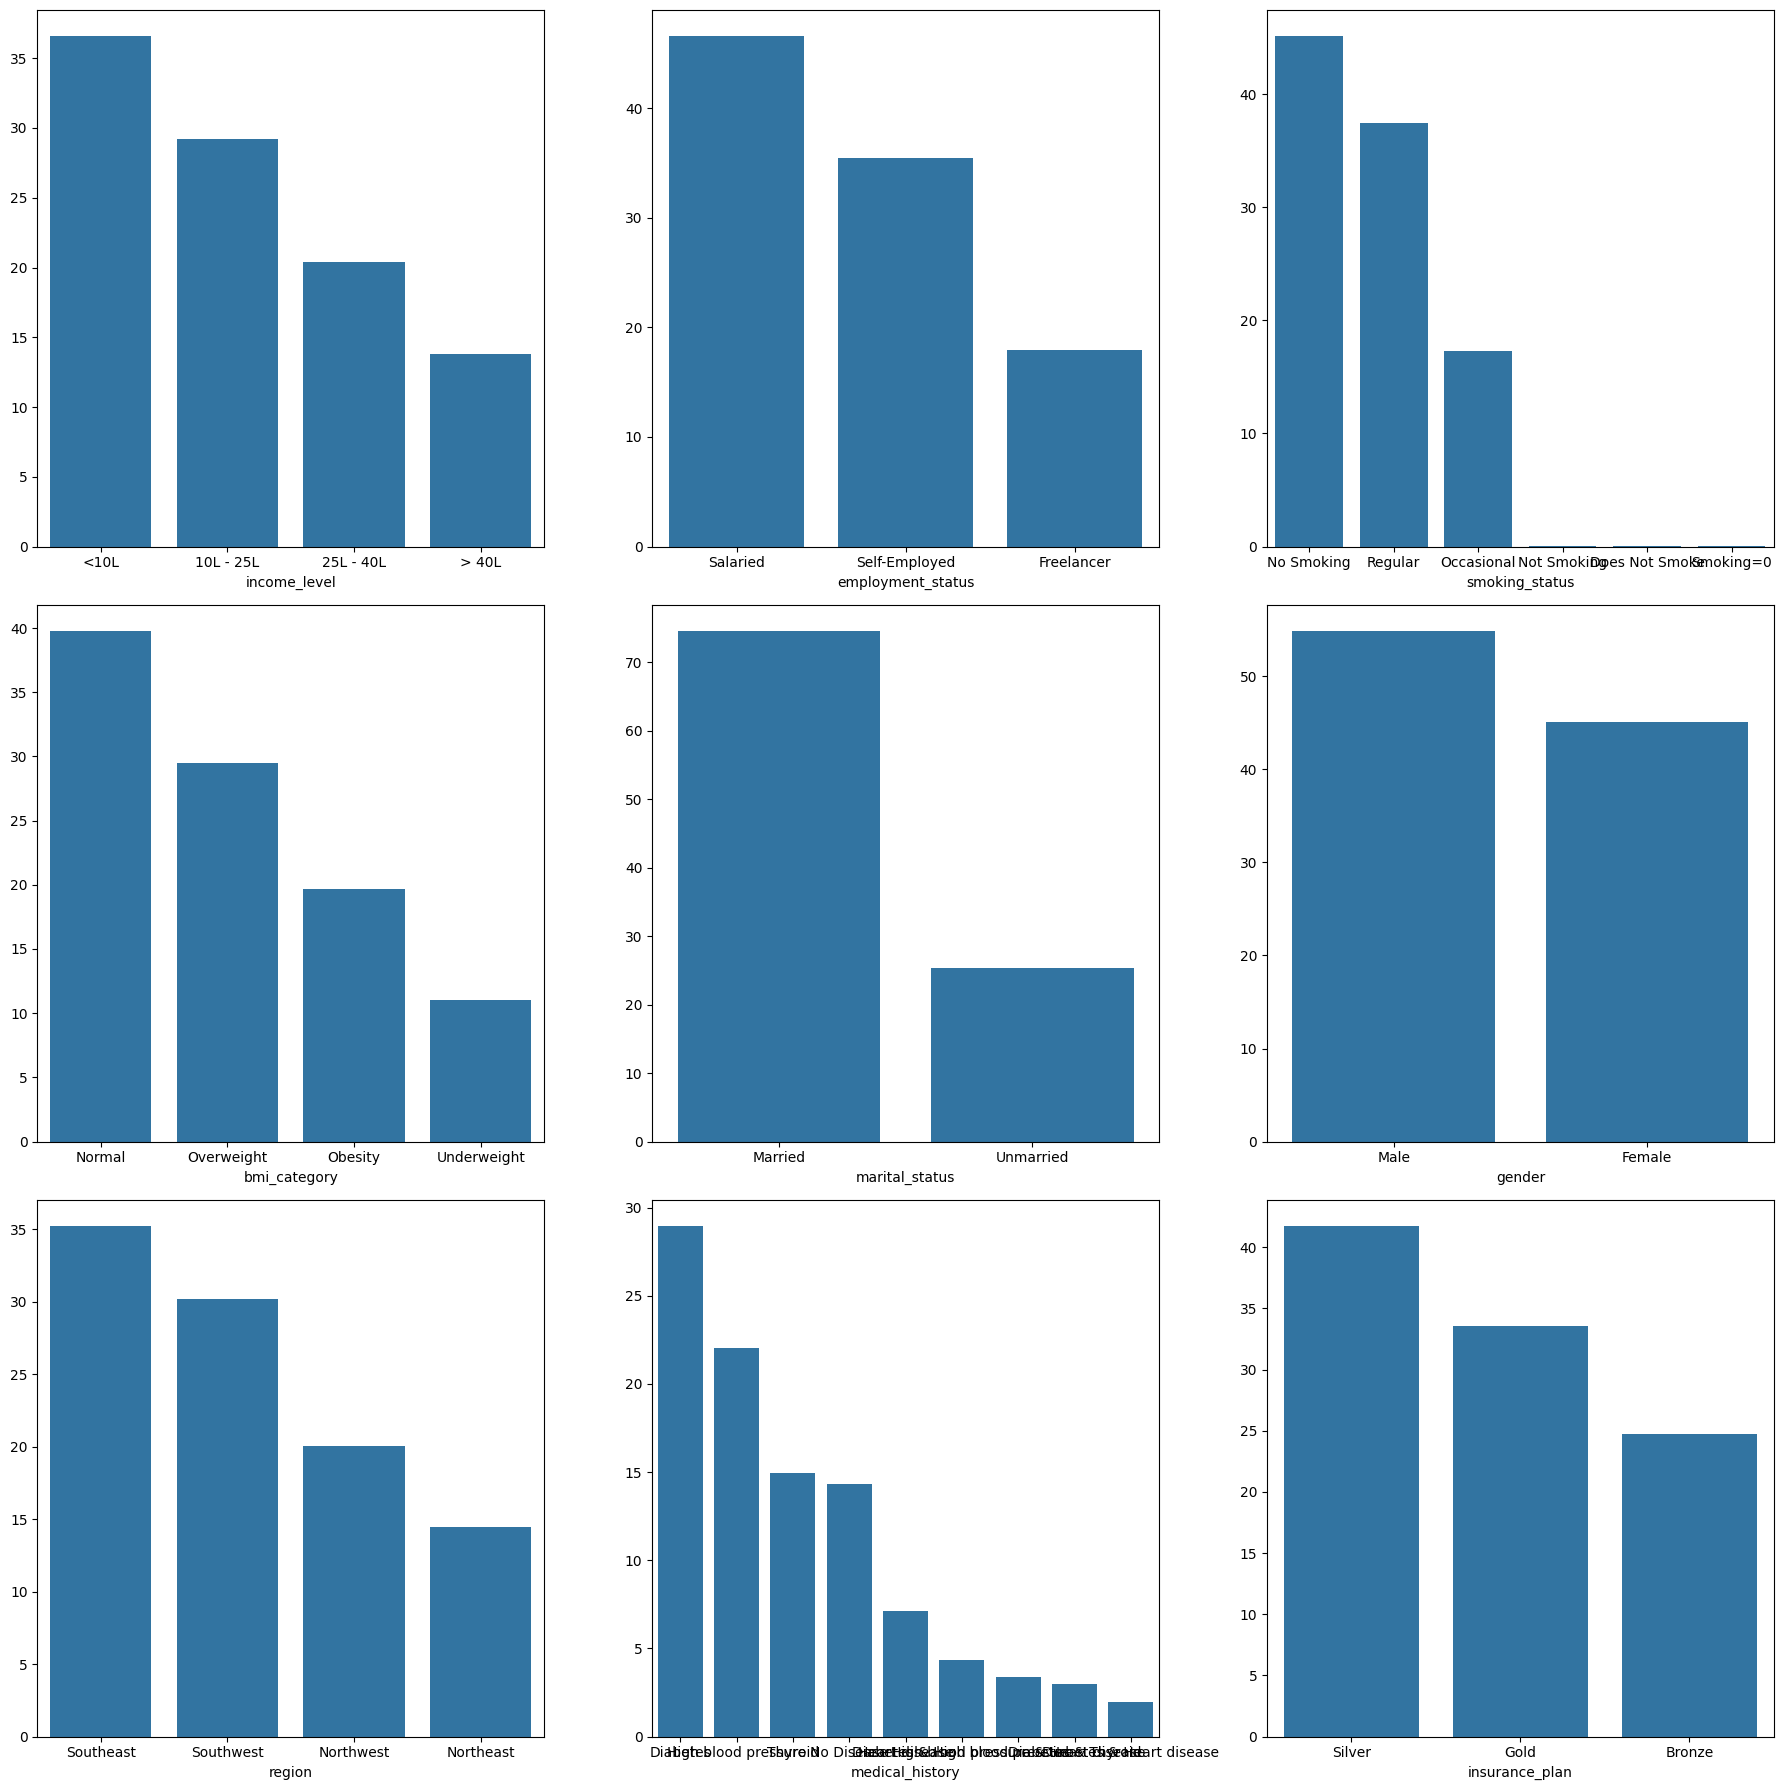

In [24]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()
for axx, column in zip(axes, categorical_columns):

    category_counts = df2[column].value_counts(normalize=True) * 100
    
    sns.barplot(x = category_counts.index, y = category_counts.values, ax=axx)

plt.tight_layout()
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L          806  3560    4361
25L - 40L          304  2635    3145
<10L              6067   527    4350
> 40L              214  3296     621


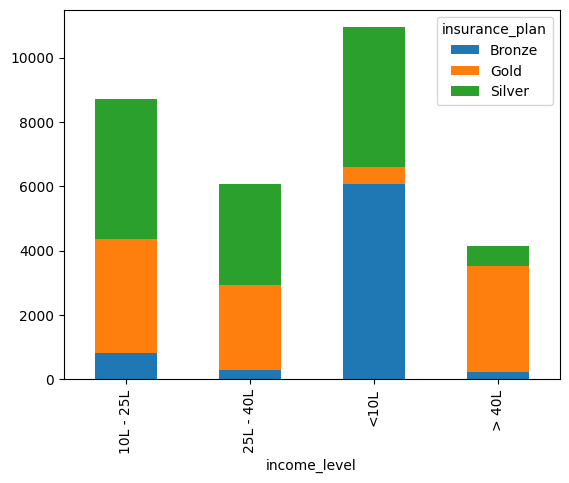

In [25]:
# For bivariate analysis
crosstab = pd.crosstab(df['income_level'], df['insurance_plan'])
print(crosstab)

crosstab.plot(kind='bar', stacked=True);

## Feature Engineering

In [26]:
df2['medical_history'].unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [27]:
# Let's create a column 'risk_score' for rating the risk according to existing diseases

risk_scores={
    "diabetes":6,
    "heart disease":8,
    "high blood pressure":6,
    "thyroid":5,
    "no disease":0,
    "none":0
}

In [28]:
df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())

In [29]:
df2['disease2'] = df2['disease2'].fillna('none')

In [30]:
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

# normalizing the risk scores
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()

df2['normalized_risk_score'] = (df2['total_risk_score']-min_score)/(max_score-min_score)

df2['total_risk_score']
df2['disease1'].unique(), df2['disease2'].unique()

(array(['diabetes', 'high blood pressure', 'no disease', 'thyroid',
        'heart disease'], dtype=object),
 array(['none', 'high blood pressure', 'heart disease', 'thyroid'],
       dtype=object))

In [31]:
# Label encoding for insurance_plan and income level

df2['insurance_plan'] = df2.insurance_plan.map({'Bronze':1, 'Silver':2, 'Gold':3})

df2['income_level'] = df2.income_level.map({'<10L':1, '10L - 25L':2, '25L - 40L':3, '> 40L':4})

In [32]:
# Doing one hot encoding for nominal columns

nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']

df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)

df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_No Smoking,smoking_status_Not Smoking,smoking_status_Occasional,smoking_status_Regular,smoking_status_Smoking=0,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,0,1,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,0,0,0,1,0,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,1,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,no disease,none,0,...,0,0,0,1,0,0,0,0,1,0
4,56,3,2,14,Diabetes,1,15610,diabetes,none,6,...,1,0,0,0,0,1,0,0,0,1


In [33]:
# Dropping unnecessary columns

df4 = df3.drop(['disease1', 'disease2', 'medical_history', 'total_risk_score'], axis=1)
df4

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,...,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_No Smoking,smoking_status_Not Smoking,smoking_status_Occasional,smoking_status_Regular,smoking_status_Smoking=0,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,...,0,0,0,1,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,...,1,0,0,0,0,0,1,0,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,30,3,4,77,3,20303,0.000000,0,0,1,...,0,0,0,1,0,0,0,0,1,0
4,56,3,2,14,1,15610,0.428571,1,0,0,...,1,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29899,60,3,3,26,3,26370,0.428571,0,1,0,...,0,0,0,1,0,0,0,0,0,1
29900,40,0,2,16,3,29496,0.785714,0,0,1,...,0,1,0,0,0,0,1,0,1,0
29901,37,0,1,4,1,10957,0.000000,0,1,0,...,1,0,0,1,0,0,0,0,1,0
29902,47,2,4,82,3,27076,0.357143,0,0,1,...,0,0,0,1,0,0,0,0,1,0


In [34]:
scaler = MinMaxScaler()

X = df4.drop('annual_premium_amount', axis=1)
y = df4['annual_premium_amount']

cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,...,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_No Smoking,smoking_status_Not Smoking,smoking_status_Occasional,smoking_status_Regular,smoking_status_Smoking=0,employment_status_Salaried,employment_status_Self-Employed
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,...,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,0.371628,0.477547,0.371225,0.224509,0.544112,0.426373,0.549125,0.200691,0.352693,0.301992,...,0.196835,0.295051,0.110087,0.451714,0.000201,0.173228,0.374656,0.000101,0.466132,0.354269
std,0.240053,0.284129,0.351111,0.226822,0.379009,0.240084,0.497589,0.400524,0.477816,0.459129,...,0.397613,0.456073,0.313003,0.497671,0.014183,0.378450,0.484042,0.010029,0.498860,0.478299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173913,0.200000,0.000000,0.060606,0.500000,0.357143,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.347826,0.600000,0.333333,0.161616,0.500000,0.428571,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.565217,0.600000,0.666667,0.313131,1.000000,0.428571,1.000000,0.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
# 'income_level' and 'income_lakhs' seems to have higher VIF, we can drop those columns

X_refined = X.drop(['income_level'], axis=1)
X_refined.shape, y.shape
X_refined.drop(['smoking_status_Smoking=0','smoking_status_Not Smoking','smoking_status_No Smoking'], axis=1, inplace=True)
X_refined.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

## Model Training and Fine Tuning

In [36]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_refined, y, test_size=0.3, random_state=42)
print('X_train', X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test', y_test.shape)


X_train (20875, 17)
X_test (8947, 17)
y_train (20875,)
y_test (8947,)


### Training Linear Regression Model

In [37]:
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)
print('linear regression model testing data prediction',linear_reg_model.score(X_test, y_test)) # 100% !!!!!!!! LOL
print('linear regression model training data prediction',linear_reg_model.score(X_train, y_train))
y_pred_linear = linear_reg_model.predict(X_test)
print('mse:',mean_squared_error(y_test, y_pred_linear))


linear regression model testing data prediction 0.9546117251336063
linear regression model training data prediction 0.9530815646744318
mse: 2183801.881857191


### Analysis of coefficients

In [38]:
linear_reg_model.coef_, linear_reg_model.feature_names_in_

(array([ 7014.39496675, -1247.79337884,  -748.5047392 , 14840.07632438,
         6029.14742861,    42.76580366,   -76.16565671,   -25.08331687,
          -53.33779201,  -702.17193058,  3930.46262822,  1999.07429281,
          598.45525871,   855.18031748,  2816.79153464,   -73.4601338 ,
          248.75420828]),
 array(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
        'normalized_risk_score', 'gender_Male', 'region_Northwest',
        'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
        'bmi_category_Obesity', 'bmi_category_Overweight',
        'bmi_category_Underweight', 'smoking_status_Occasional',
        'smoking_status_Regular', 'employment_status_Salaried',
        'employment_status_Self-Employed'], dtype=object))

<BarContainer object of 17 artists>

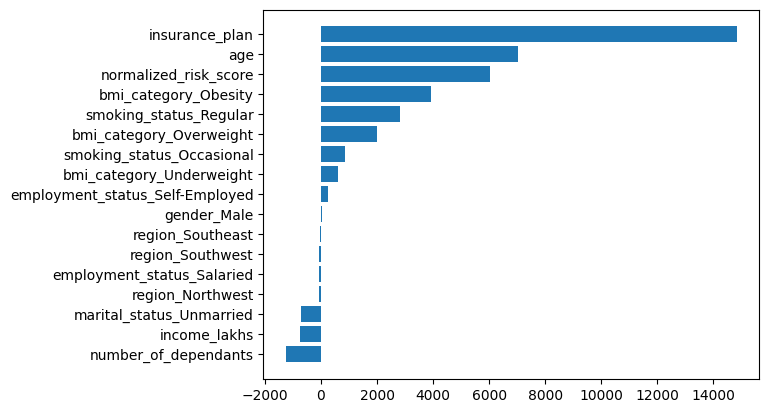

In [39]:
coef_df = pd.DataFrame({
    'columns': X_train.columns,
    'Coefficients':linear_reg_model.coef_
})

coef_df = coef_df.sort_values(by='Coefficients', ascending=True)
coef_df

plt.barh(coef_df['columns'], coef_df['Coefficients']) # insurance plan will have more impact on the predictions

### Training Ridge Regressor Model

In [40]:
ridge_model = Ridge(alpha=8)
ridge_model.fit(X_train, y_train)
print('ridge score on testing data:', ridge_model.score(X_test, y_test))
print('ridge score on training data:', ridge_model.score(X_train, y_train))

ridge score on testing data: 0.954607188392988
ridge score on training data: 0.953070904307108


#### Training XGBoost Model

In [41]:
xgb_model = XGBRegressor(n_estimators=20, max_depth=3)
xgb_model.fit(X_train, y_train)
print('xgb model score for testing data:',xgb_model.score(X_test, y_test))
print('xgb model score for training data:',xgb_model.score(X_train, y_train))

xgb model score for testing data: 0.9950187802314758
xgb model score for training data: 0.995059072971344


#### Calculating MSE and RMSE for XGBoost model

In [42]:
y_pred_xgb = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
print('this is xgboost mse: ', mse, 'and this is rmse for xgboost',rmse)

this is xgboost mse:  239665.8125 and this is rmse for xgboost 489.5567510513975


#### Using randomized search cv for getting the best parameters and best model

In [43]:
xgb_model_regressor = XGBRegressor()
#Parameters Grid
param_selection_grid={
    'n_estimators':[20, 40, 50],
    'learning_rate':[0.1, 0.2, 0.3],
    'max_depth':[3, 4, 5]
}

random_search = RandomizedSearchCV(xgb_model_regressor, param_selection_grid, n_iter=3, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print('randomized search best score: ', random_search.best_score_)
print('best estimator is:', best_model)
print('best params are:', random_search.best_params_)

randomized search best score:  0.9977756142616272
best estimator is: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=40,
             n_jobs=None, num_parallel_tree=None, ...)
best params are: {'n_estimators': 40, 'max_depth': 4, 'learning_rate': 0.2}


#### Plotting bar graph and analyzing coefficients for XGBoost Model

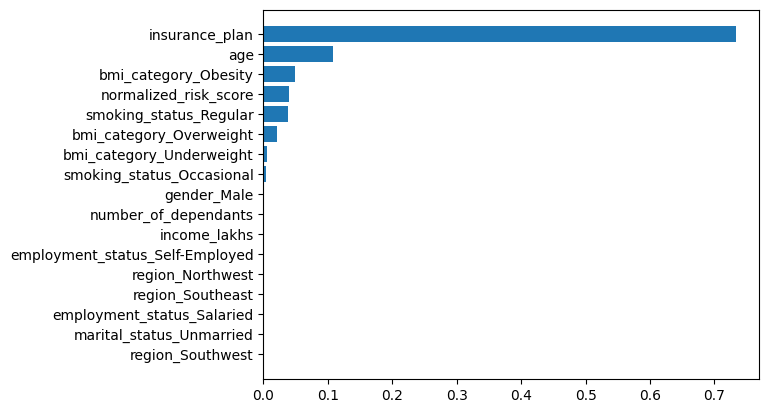

In [44]:
coef_df = pd.DataFrame({
    'columns': X_train.columns,
    'Coefficients':xgb_model.feature_importances_
})
# Tree based models use feature_importances, linear model uses coef_

coef_df = coef_df.sort_values(by='Coefficients', ascending=True)
coef_df

plt.barh(coef_df['columns'], coef_df['Coefficients']);

### Error Analysis

In [45]:
y_pred = best_model.predict(X_test)
residuals = y_pred - y_test
residual_percentage = (residuals/y_test)*100

error_results = pd.DataFrame({
    'actual':y_test,
    'predicted':y_pred,
    'residual':residuals,
    'residual_percentage':residual_percentage
})

error_results.head()

,actual,predicted,residual,residual_percentage
5495,30838,31228.263672,390.263672,1.265528
582,26306,26242.035156,-63.964844,-0.243157
281,17983,17578.355469,-404.644531,-2.250150
15443,19345,19005.324219,-339.675781,-1.755884
24281,33317,33417.558594,100.558594,0.301824


<AxesSubplot: xlabel='residual_percentage', ylabel='Count'>

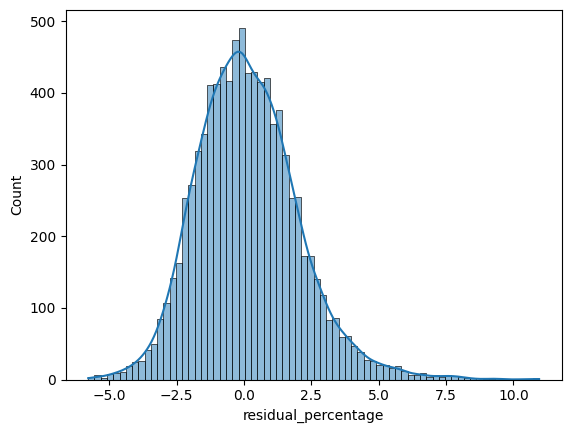

In [46]:
sns.histplot(error_results['residual_percentage'], kde=True)

In [47]:
extreme_error_results = error_results[np.abs(error_results.residual_percentage)>10]

print('percentage of error more than 10%', extreme_error_results.shape[0]*100/error_results.shape[0])

extreme_error_results.head()

percentage of error more than 10% 0.03353079244439477


,actual,predicted,residual,residual_percentage
6137,6538,7254.269531,716.269531,10.955484
8270,6548,7254.269531,706.269531,10.786034
17811,6569,7254.269531,685.269531,10.431870


In [48]:
X_test.index

Index([ 5495,   582,   281, 15443, 24281, 13879, 23869,  9985,  1989, 29096,
       ...
        9378, 21318, 11748, 12471, 27270, 12305,  2117, 23521, 29683, 11077],
      dtype='int64', length=8947)

In [49]:
extreme_error_results.index # these are the rows in X_test which has high margin errors

Index([6137, 8270, 17811], dtype='int64')

In [50]:
X_test.loc[extreme_error_results.index].shape

(3, 17)

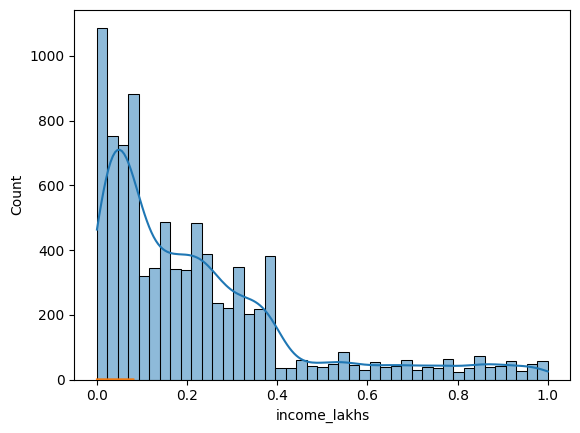

In [51]:
extreme_error_df = X_test.loc[extreme_error_results.index]
extreme_error_df.head()
sns.histplot(X_test.income_lakhs, kde=True)
sns.histplot(extreme_error_df.income_lakhs, kde=True)
plt.show()

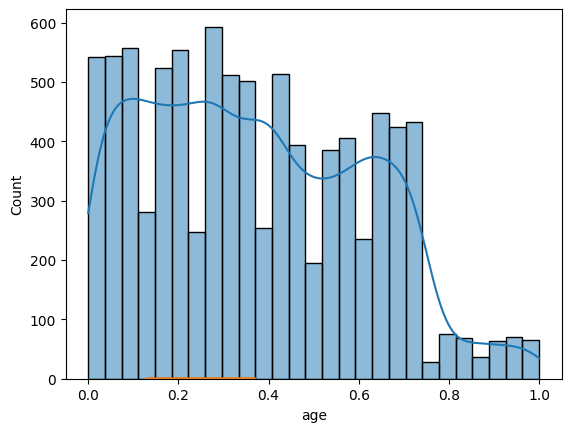

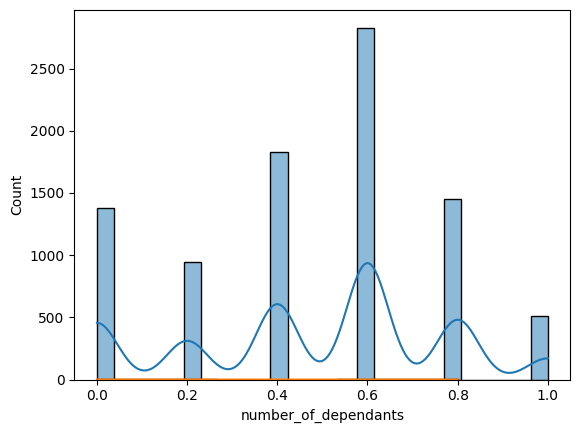

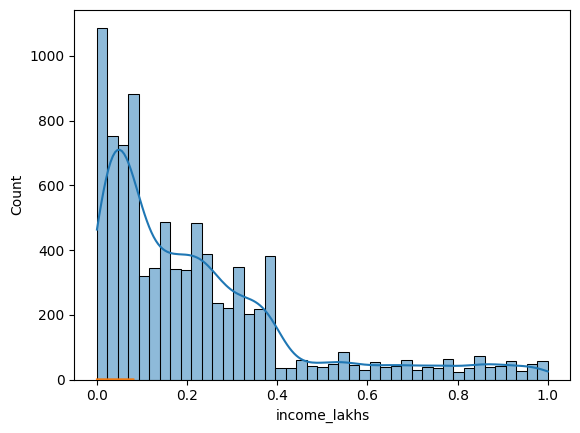

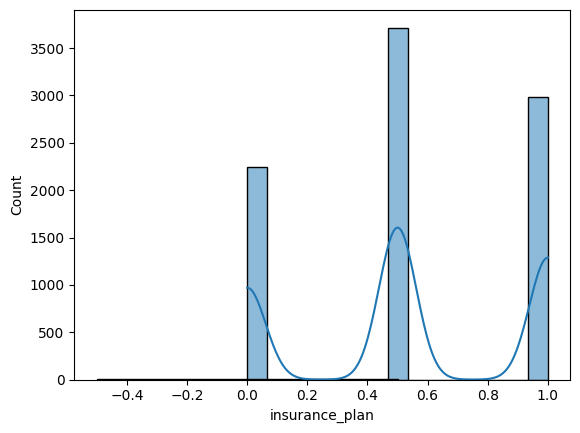

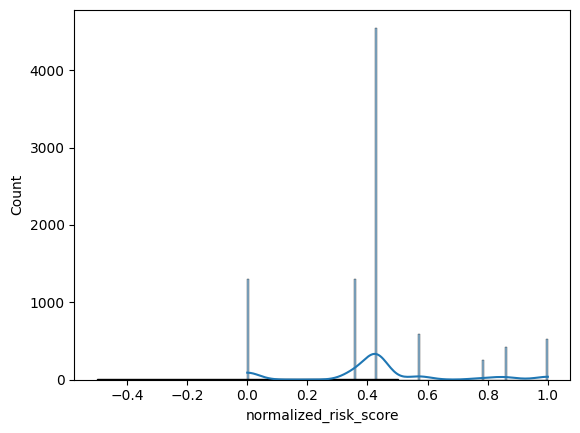

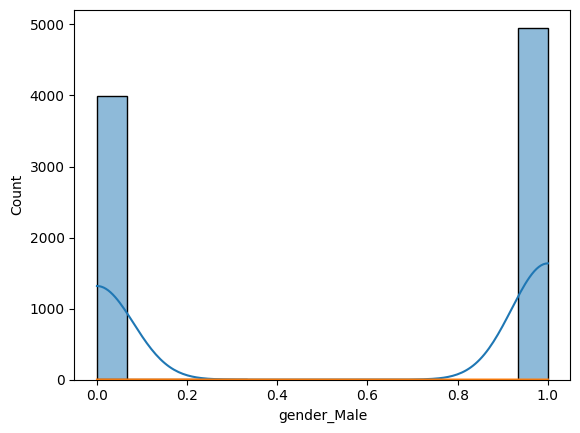

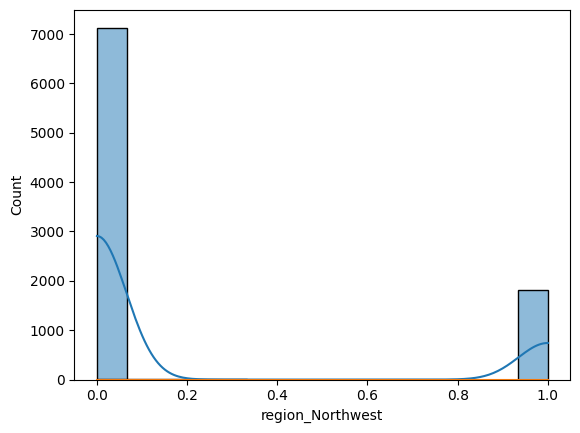

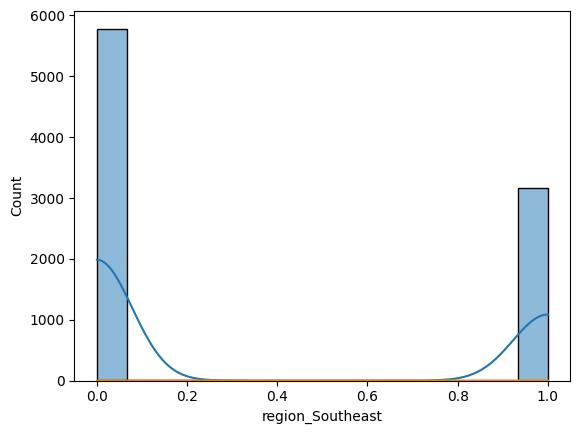

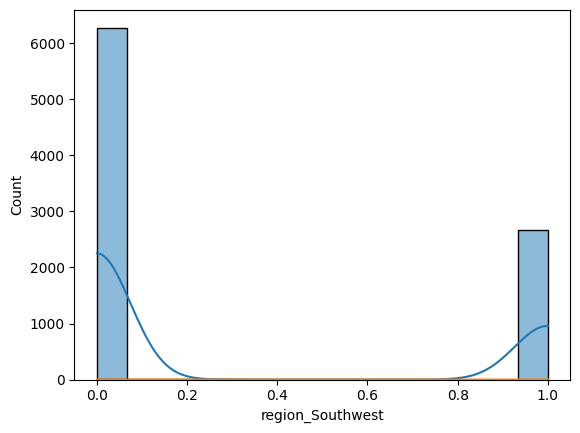

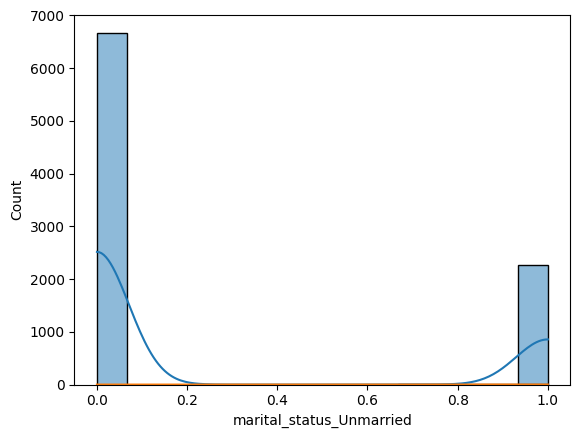

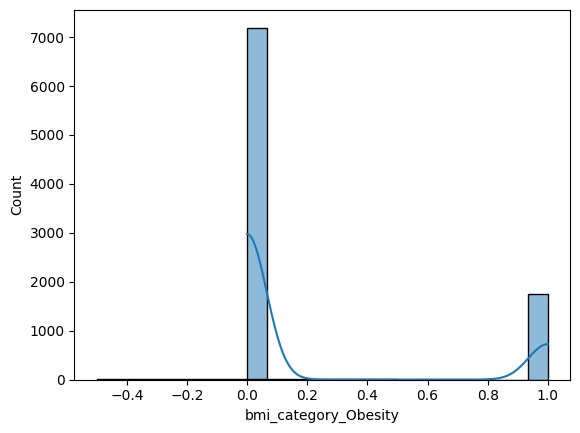

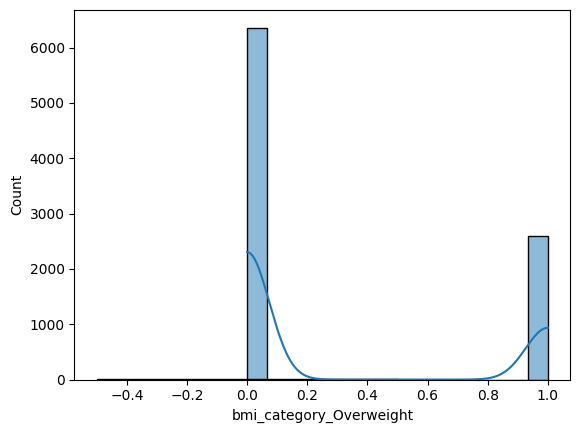

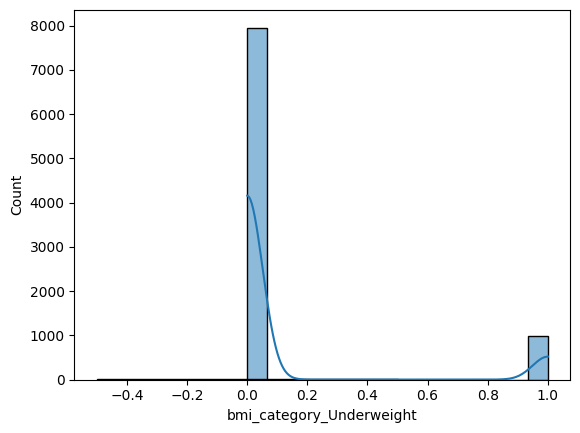

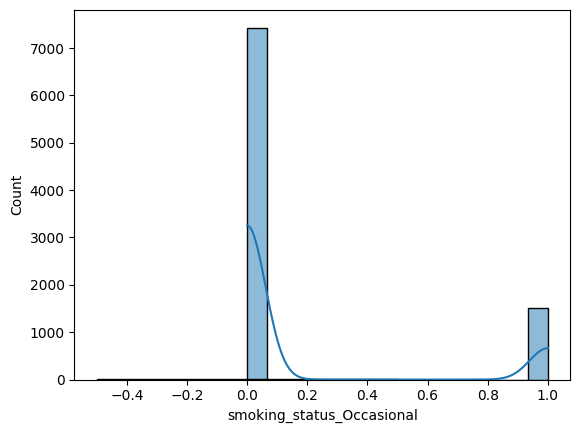

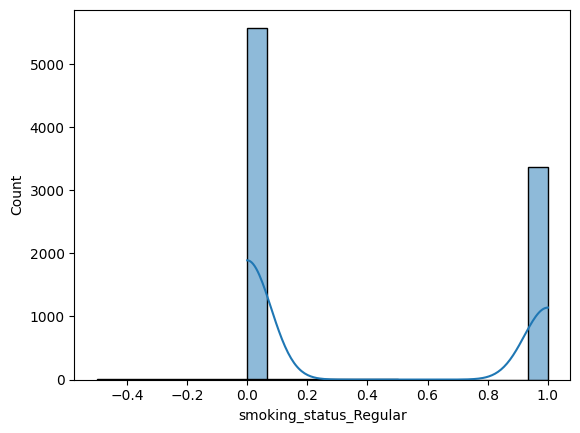

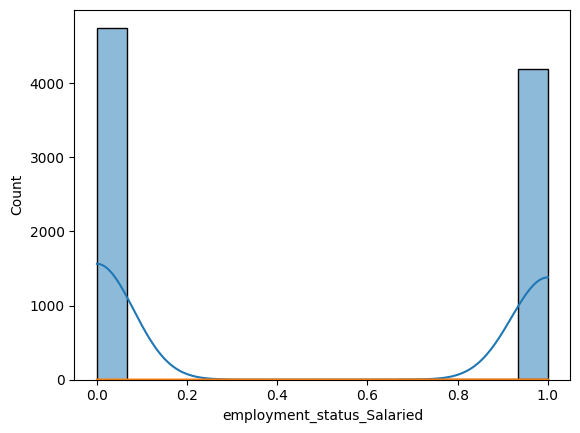

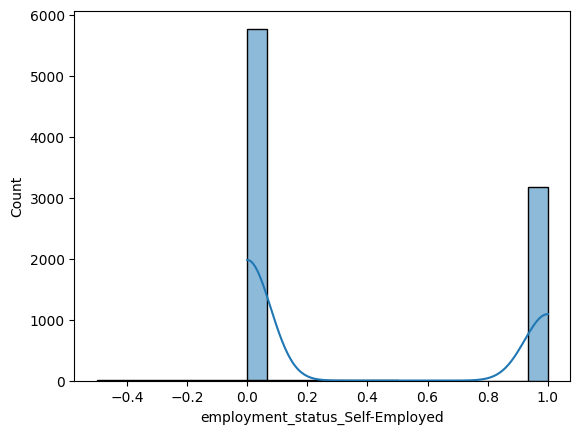

In [52]:
# Plotting histplot for all fetures
for featuree in X_test.columns:
    sns.histplot(X_test[featuree], kde=True)
    sns.histplot(extreme_error_df[featuree], kde=True)
    plt.show()

In [53]:
# Seems like age column has something fishy
extreme_error_df['income_level'] = -1
reversed_scaling = pd.DataFrame()
reversed_scaling[cols_to_scale] = scaler.inverse_transform(extreme_error_df[cols_to_scale])
reversed_scaling['age'].quantile(0.98) # Almost 98 percent of population in extreme error df is 25 years of age or less

42.84

In [55]:
print(cols_to_scale)

print(scaler.data_min_)

print(scaler.data_max_)

['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']
[26.  0.  1.  1.  1.]
[ 72.   5.   4. 100.   3.]
